In [1]:
"""
  python= 3.10.0
  pandas= 1.5.2
  psndas_datareader= 0.10.0
  numpy= 1.23.5
  scikit-learn= 1.1.3
  matplotlib= 3.6.2
"""
import pandas as pd
import datetime
import math
import numpy as np
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
from sklearn import preprocessing, model_selection, svm


In [2]:
#Load dataset, find Apple lnc.
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime.today()
df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-12-02,148.000000,145.649994,145.960007,147.809998,65421400.0,147.809998
2022-12-05,150.919998,145.770004,147.770004,146.630005,68826400.0,146.630005
2022-12-06,147.300003,141.919998,147.070007,142.910004,64727200.0,142.910004
2022-12-07,143.369995,140.000000,142.190002,140.940002,69721100.0,140.940002
2022-12-08,143.520004,141.100006,142.360001,142.649994,62072600.0,142.649994


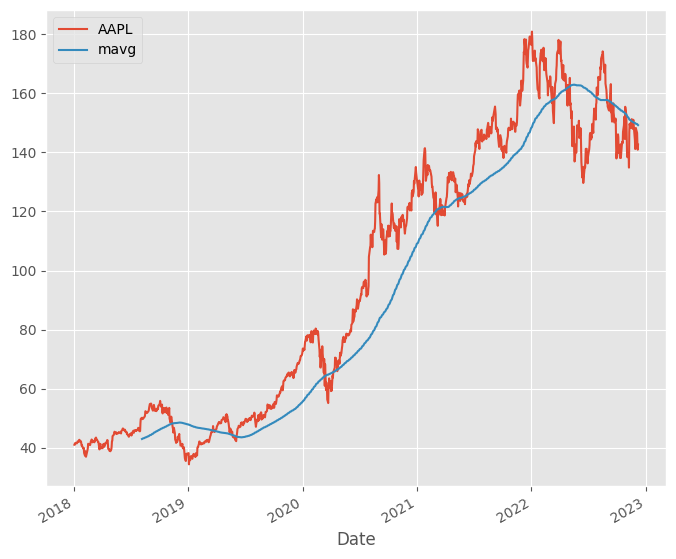

In [3]:
#Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=150).mean()

%matplotlib inline
# Adjusting the matplotlib
mpl.rc('figure', figsize=(8, 7))
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

In [4]:
#Percent change
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2018-01-02,40.950497,102223600.0,1.764779,1.234127
2018-01-03,40.943363,118071600.0,1.503801,-0.173885
2018-01-04,41.133549,89738400.0,0.803329,0.283995
2018-01-05,41.601860,94640000.0,1.325710,0.899445
2018-01-08,41.447350,82271200.0,0.963584,0.000000


In [5]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
print(dfreg.shape)

# separate 2 percent of the data to forecast
forecast_out = int(math.ceil(0.02 * len(dfreg)))

# Separating the label
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], axis=1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('forecast_out:',forecast_out)
print('Dimension of X:',X.shape)
print('Dimension of y:',y.shape)

(1244, 4)
forecast_out: 25
Dimension of X: (1219, 4)
Dimension of y: (1219,)


In [6]:
# Separation of training and testing of mode: 80% for training
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [7]:
#sSklearn regression, OWN CODE
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clfreg = LinearRegression(n_jobs=3)
clfreg.fit(X_train, y_train)

# Quadratic Regression: degree=2
clfpoly2 = make_pipeline(PolynomialFeatures(), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression: degree=3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
    
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=3)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [8]:
# Evaluation the training, OWN CODE
print("The confidence:")
print("Linear regression      ",clfreg.score(X_test, y_test),'\n'
      "Quadratic regression 2 ",clfpoly2.score(X_test,y_test),'\n'
      "Quadratic regression 3 ",clfpoly3.score(X_test,y_test),'\n'
      "Knn regression         ",clfknn.score(X_test, y_test))

The confidence:
Linear regression       0.9557933762411347 
Quadratic regression 2  0.9627873341391854 
Quadratic regression 3  0.9618221857287678 
Knn regression          0.9344368057569492


 ===== clfreg data =====
[139.41005641 138.87556705 140.38523152 140.59278891 136.10244078
 148.28236628 151.03707943 149.23892771 150.75393111 149.8938163
 152.25959015 152.07180889 149.06506875 151.79515265 152.38174395
 149.66111998 145.41911336 142.14467458 149.72711124 149.34592404
 149.12461449 147.94987655 144.16135627 142.22642806 144.05478766]
 ===== clfpoly2 data =====
[141.4640305  136.14251667 143.79800817 143.25679882 139.42880919
 149.43970469 152.0767791  150.35329155 150.25497911 151.38364875
 154.00522476 152.136788   150.89840732 154.57737561 153.72523572
 153.02268344 147.95565968 143.94939832 151.66751658 150.47384883
 150.72883881 149.57264738 144.87043895 145.46781042 147.3016702 ]
 ===== clfpoly3 data =====
[144.3088517  134.64283706 144.41168441 144.78307809 142.99613257
 148.20357978 151.16890548 151.00293091 151.32076632 151.84591631
 153.49338101 152.54433817 152.72238157 154.65558499 153.55850431
 154.03952791 149.44864478 146.59603036 149.83111841 150.68324

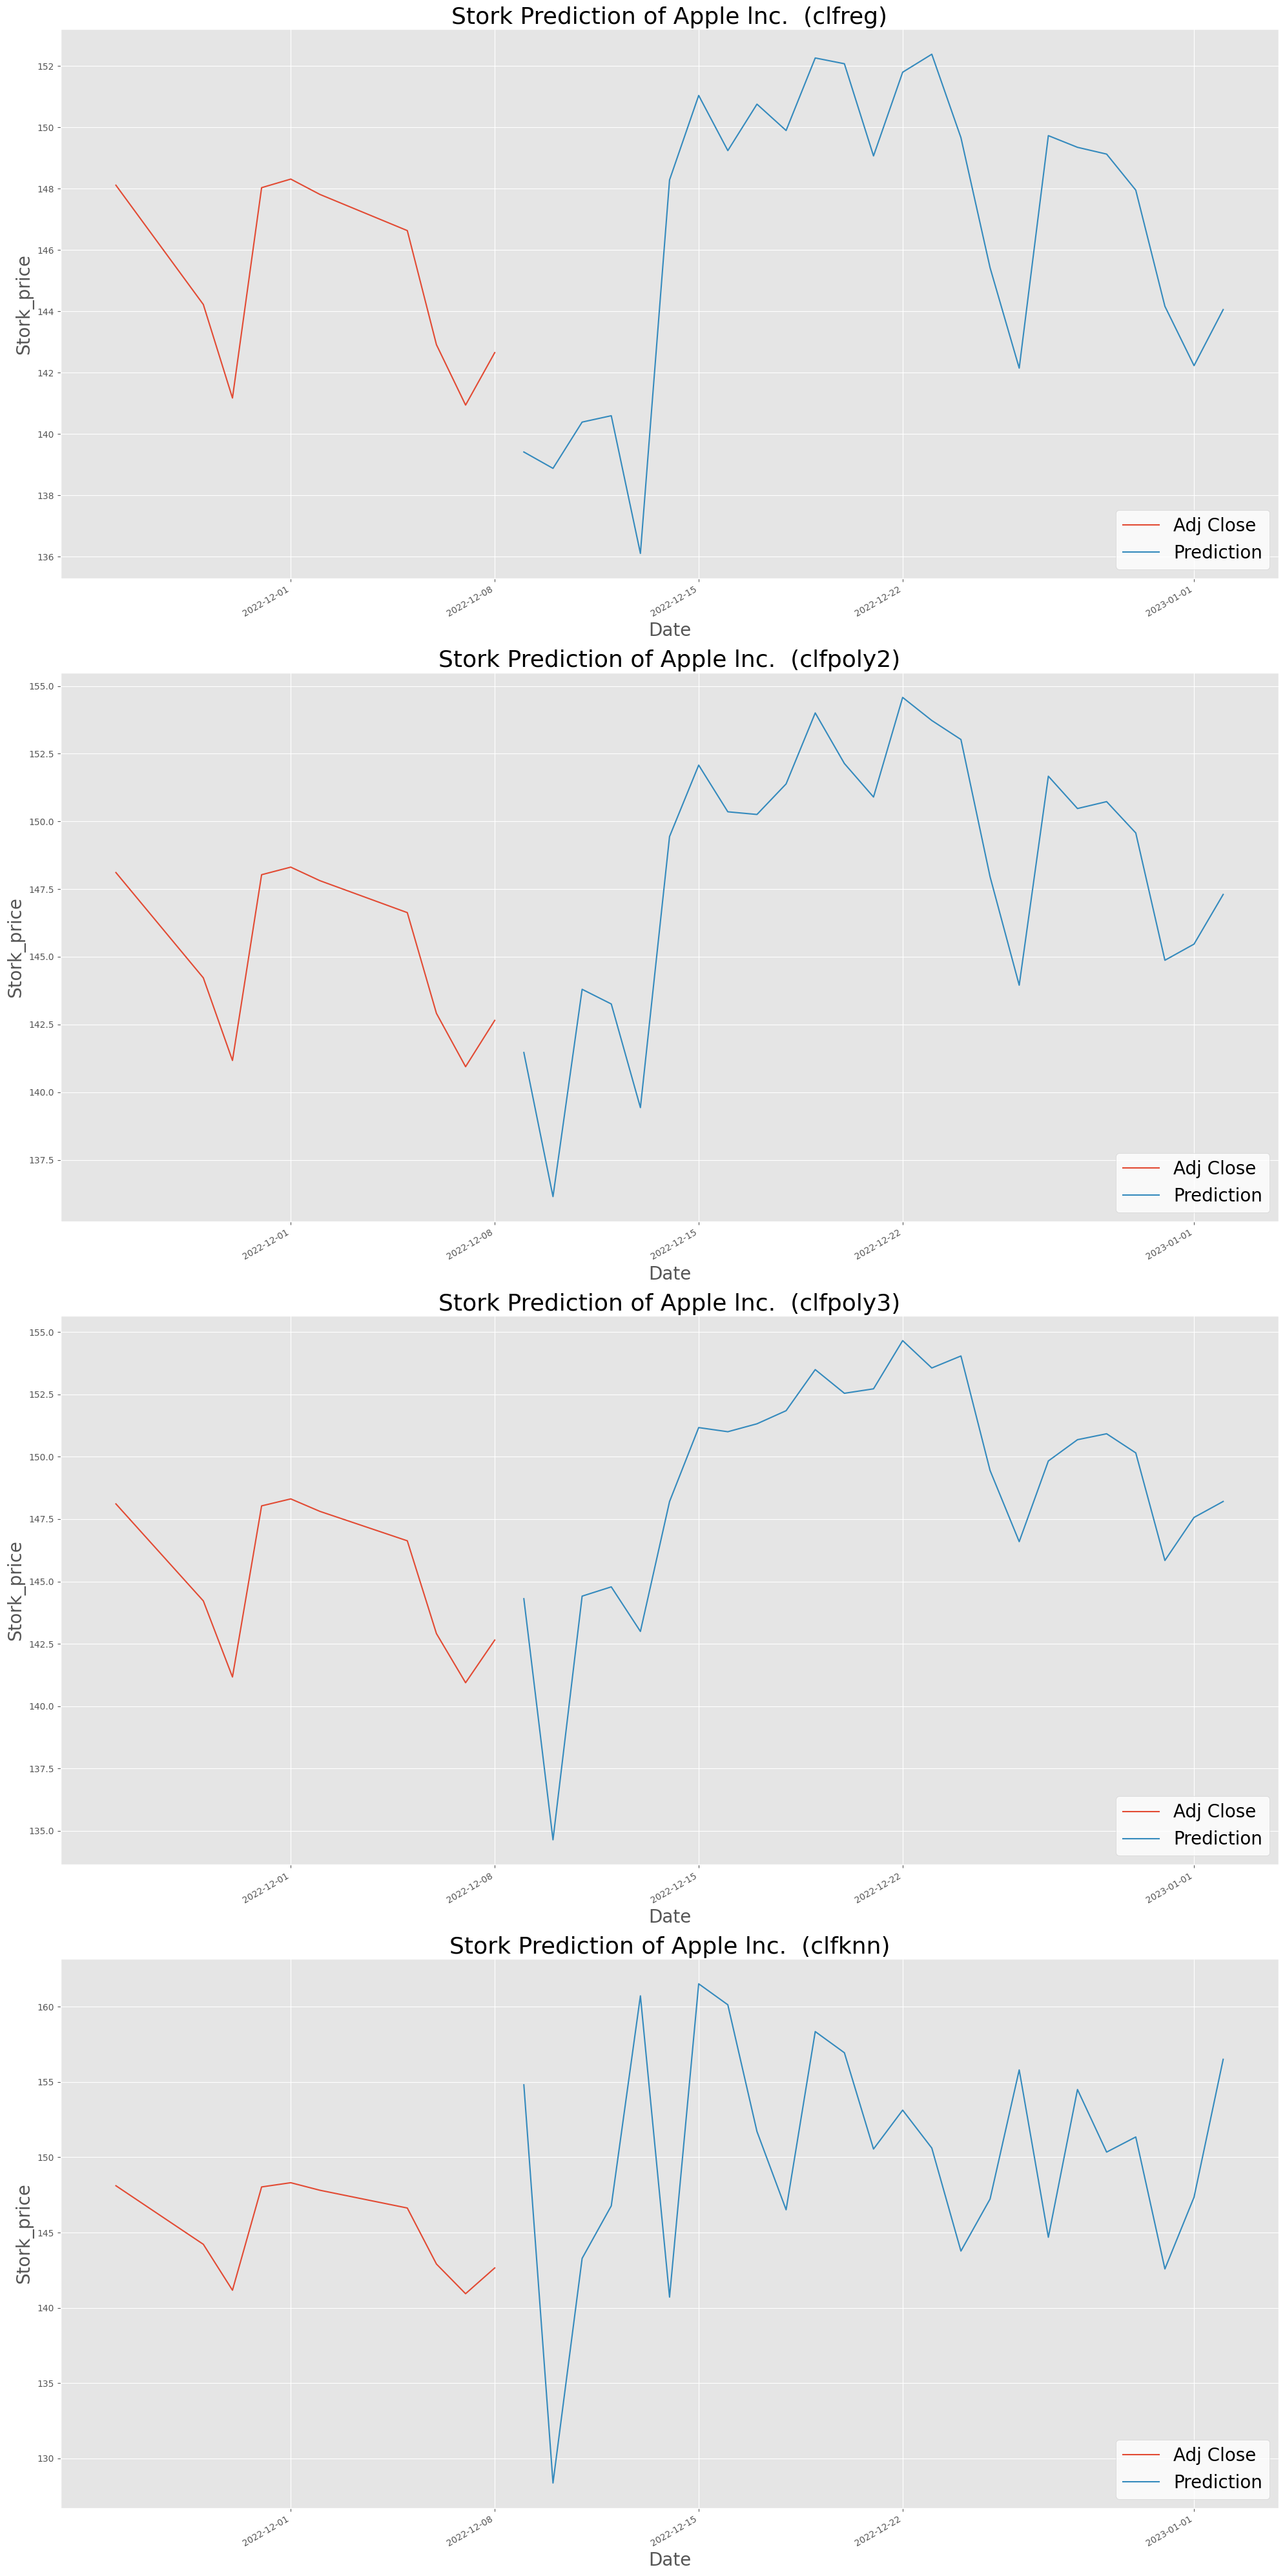

In [9]:
# Plot, OWN CODE
forecast_set = [clfreg.predict(X_lately),
                clfpoly2.predict(X_lately),
                clfpoly3.predict(X_lately),
                clfknn.predict(X_lately)]
dfreg['Prediction'] = np.nan
next_u = dfreg.iloc[-1].name + datetime.timedelta(days=1)
k=0
plt.figure(figsize=(20, 40))
for i, meth in enumerate(["clfreg","clfpoly2","clfpoly3","clfknn"]):
    for j in forecast_set[i]:
        next_date = next_u
        next_u += datetime.timedelta(days=1)
        dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[j]
        if(k<forecast_out-1):
            k += 1
        else:
            next_u = dfreg.iloc[-1-forecast_out].name + datetime.timedelta(days=1)
            k = 0
            break
    print(' =====',meth,'data =====')
    print(forecast_set[i])
    plt.subplot(4, 1, i+1)
    dfreg['Adj Close'].tail(forecast_out+10).plot()
    dfreg['Prediction'].tail(forecast_out).plot()
    plt.title("Stork Prediction of Apple lnc.  (%s)" % (meth), fontsize = 26)
    plt.legend(loc=4,facecolor='w', fontsize = 20)
    plt.xlabel('Date', fontsize = 20)
    plt.ylabel('Stork_price', fontsize = 20)
plt.tight_layout()
plt.show()